![alt text](Quest√£o1.png)

=== Matriz de H√ºckel H (eV) ===
          O(1)      C(2)      N(3)      C(4)      C(5)
O(1) -2.500000 -2.000000  0.000000  0.000000 -2.000000
C(2) -2.000000  0.000000 -2.500000  0.000000  0.000000
N(3)  0.000000 -2.500000 -1.250000 -2.000000  0.000000
C(4)  0.000000  0.000000 -2.000000  0.000000 -2.750000
C(5) -2.000000  0.000000  0.000000 -2.750000  0.000000

=== k usados por liga√ß√£o ===
O(1)‚ÄìC(2): k = 0.800
C(2)‚ÄìN(3): k = 1.000
N(3)‚ÄìC(4): k = 0.800
C(4)‚ÄìC(5): k = 1.100
C(5)‚ÄìO(1): k = 0.800

=== Energias (eV) ===
MO1: -5.357236
MO2: -2.662018
MO3: -1.961425 (HOMO)
MO4: 2.671873 (LUMO)
MO5: 3.558805

=== Orbitais Moleculares (combina√ß√£o linear) ===
œà_MO1 = +0.577*O(1) +0.419*C(2) +0.435*N(3) +0.371*C(4) +0.406*C(5)
œà_MO2 = +0.658*O(1) -0.118*C(2) -0.652*N(3) -0.313*C(4) +0.171*C(5)
œà_MO3 = -0.209*O(1) -0.514*C(2) -0.236*N(3) +0.558*C(4) +0.570*C(5)
œà_MO4 = +0.415*O(1) -0.714*C(2) +0.431*N(3) +0.047*C(4) -0.360*C(5)
œà_MO5 = +0.133*O(1) +0.192*C(2) -0.379*N(3) +0.671*

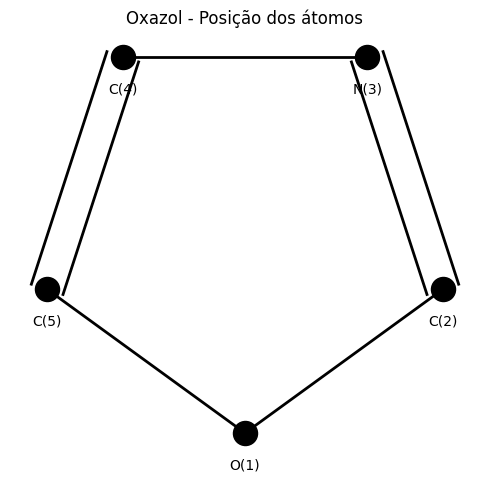

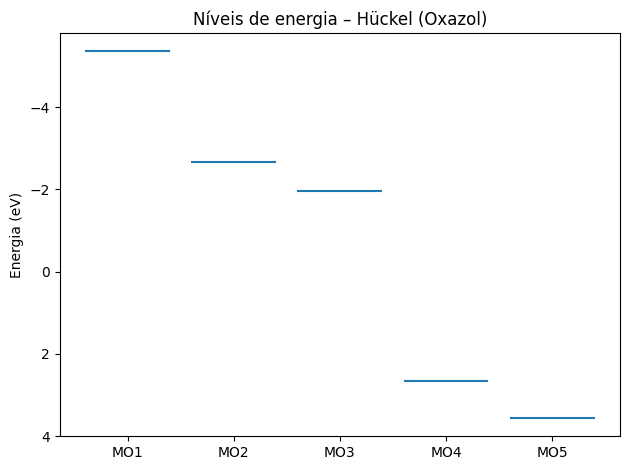

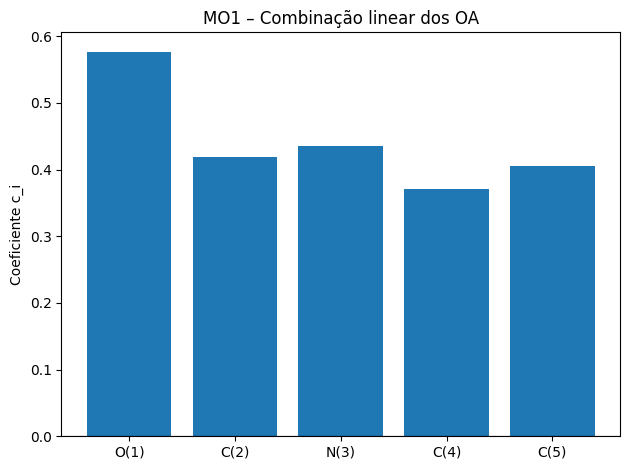

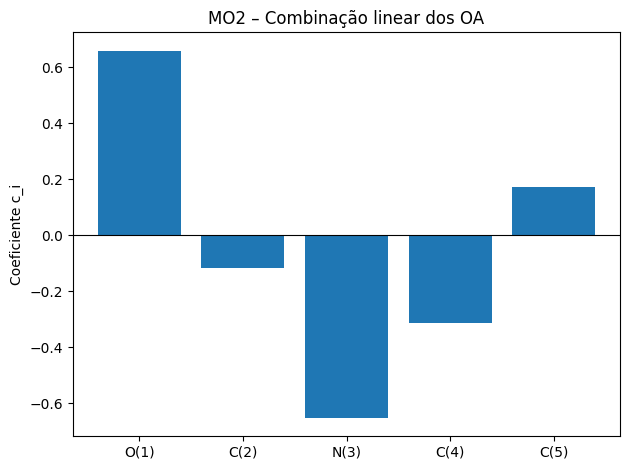

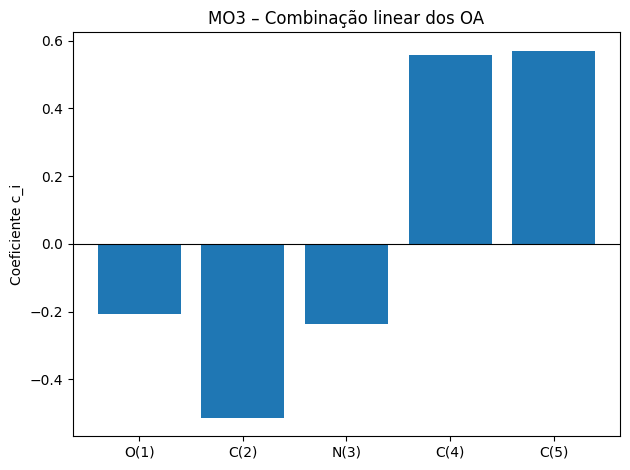

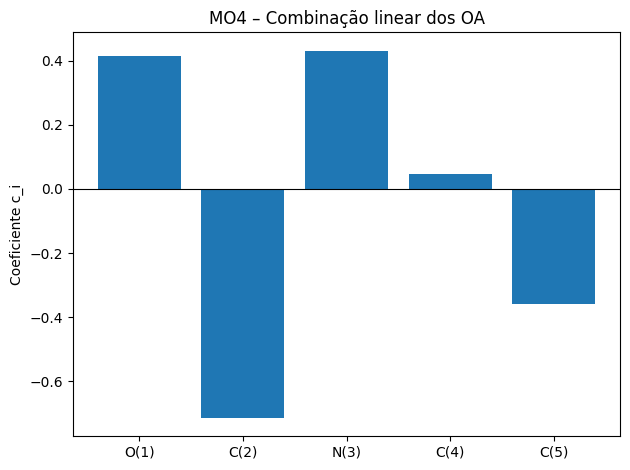

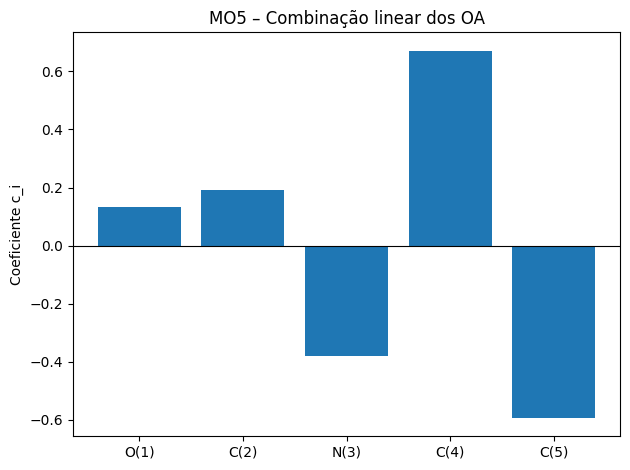

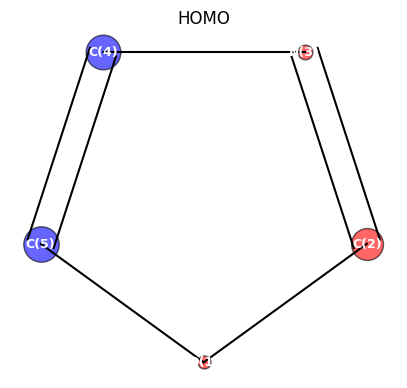

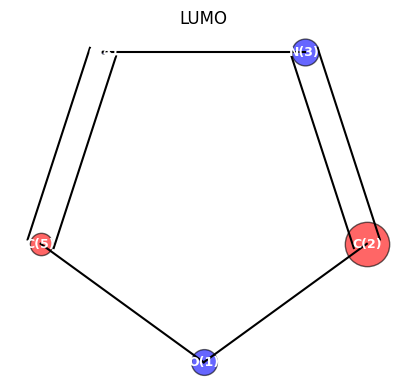

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# 1) Par√¢metros
# -------------------------
beta0  = -2.5  # eV
alphaC = 0.0

h = {
    "C": 0.0,
    "N_piridina": 0.5,
    "O_furano":   1.0,
}

k_aromatic = {
    ("C","C"): 1.0,
    ("C","N_piridina"): 0.8,
    ("C","O_furano"):   0.8,
}

# -------------------------
# 2) Mol√©cula (ordem desejada)
# -------------------------
atoms  = ["O_furano", "C", "N_piridina", "C", "C"]
labels = ["O(1)", "C(2)", "N(3)", "C(4)", "C(5)"]

bonds = [
    (0, 1, "aromatic"),  # O‚ÄìC
    (1, 2, "double"),    # C=N
    (2, 3, "aromatic"),  # N‚ÄìC
    (3, 4, "double"),    # C=C
    (4, 0, "aromatic"),  # C‚ÄìO
]

# -------------------------
# 2b) Coordenadas 2D
# -------------------------
r = 1.0
angles_deg = -90 + np.arange(5) * 72.0
angles = np.deg2rad(angles_deg)
coords = np.column_stack((r * np.cos(angles), r * np.sin(angles)))

# -------------------------
# 3) Matriz de H√ºckel
# -------------------------
n = len(atoms)
H = np.zeros((n, n))
for i, ax in enumerate(atoms):
    H[i, i] = alphaC + h[ax] * beta0

def k_default(a_i, a_j):
    if (a_i, a_j) in k_aromatic:
        return k_aromatic[(a_i, a_j)]
    if (a_j, a_i) in k_aromatic:
        return k_aromatic[(a_j, a_i)]
    return 0.0

def k_for_bond(i, j, bond_type):
    ai, aj = atoms[i], atoms[j]
    if bond_type == "double":
        if {"N_piridina","C"} == {ai, aj}:
            return 1.0
        if ai == "C" and aj == "C":
            return 1.1
        return 1.0
    elif bond_type == "single":
        if {"N_piridina","C"} == {ai, aj}:
            return 0.7
        if ai == "C" and aj == "C":
            return 0.9
        if {"O_furano","C"} == {ai, aj}:
            return 0.8
        return k_default(ai, aj)
    else:
        return k_default(ai, aj)

k_used = {}
for i, j, btype in bonds:
    kij = k_for_bond(i, j, btype)
    H[i, j] = H[j, i] = kij * beta0
    k_used[(i, j)] = kij

# -------------------------
# 4) Diagonaliza√ß√£o
# -------------------------
evals, evecs = np.linalg.eigh(H)

# -------------------------
# 5) Preenchimento eletr√¥nico
# -------------------------
nelec = 5
full_occ = nelec // 2
half_occ = nelec % 2

occ_e = np.zeros(n)
occ_e[:full_occ] = 2.0
if half_occ:
    occ_e[full_occ] = 1.0

occupied_idx = np.where(occ_e > 0)[0]
unoccupied_idx = np.where(occ_e == 0)[0]
HOMO_idx = occupied_idx.max()
LUMO_idx = unoccupied_idx.min()

# Popula√ß√µes e ordens
populations = np.sum((evecs**2) * occ_e, axis=1)
P = np.zeros((n, n))
for a in range(n):
    P += occ_e[a] * np.outer(evecs[:, a], evecs[:, a])

# -------------------------
# 6) Impress√£o
# -------------------------
print("=== Matriz de H√ºckel H (eV) ===")
print(pd.DataFrame(H, index=labels, columns=labels))

print("\n=== k usados por liga√ß√£o ===")
for (i,j), kij in k_used.items():
    print(f"{labels[i]}‚Äì{labels[j]}: k = {kij:.3f}")

print("\n=== Energias (eV) ===")
for m, E in enumerate(evals, 1):
    idx = m-1
    tag = " (HOMO)" if idx == HOMO_idx else (" (LUMO)" if idx == LUMO_idx else "")
    print(f"MO{m}: {E:.6f}{tag}")

print("\n=== Orbitais Moleculares (combina√ß√£o linear) ===")
for m in range(n):
    terms = [f"{evecs[i,m]:+.3f}*{labels[i]}" for i in range(n)]
    print(f"œà_MO{m+1} = " + " ".join(terms))

print("\n=== Popula√ß√µes eletr√¥nicas œÄ ===")
for lbl, Ni in zip(labels, populations):
    print(f"{lbl}: {Ni:.3f}")
print(f"Soma dos PETs: {populations.sum():.3f}")

print("\n=== Ordens de liga√ß√£o œÄ ===")
for i, j, _ in bonds:
    print(f"{labels[i]}‚Äì{labels[j]}: {P[i,j]:.3f}")

# -------------------------
# 7) Fun√ß√µes de desenho da mol√©cula (apenas este plot em preto)
# -------------------------
def draw_bond(ax, p1, p2, btype, linewidth=2.0, double_offset=0.08):
    x1, y1 = p1
    x2, y2 = p2
    dx = x2 - x1
    dy = y2 - y1
    length = np.hypot(dx, dy)
    if length == 0:
        return
    perp = np.array([-dy, dx]) / length
    if btype == "double":
        off = perp * double_offset
        ax.plot([x1+off[0], x2+off[0]], [y1+off[1], y2+off[1]], linewidth=linewidth, color='k')
        ax.plot([x1-off[0], x2-off[0]], [y1-off[1], y2-off[1]], linewidth=linewidth, color='k')
    else:
        ax.plot([x1, x2], [y1, y2], linewidth=linewidth, color='k')

# -------------------------
# 8) Plot da mol√©cula (somente este quadro √© preto)
# -------------------------
fig, ax = plt.subplots(figsize=(5,5))
for i, j, btype in bonds:
    draw_bond(ax, coords[i], coords[j], btype)

for i, (x, y) in enumerate(coords):
    ax.scatter(x, y, s=300, facecolors='k', edgecolors='k', zorder=5)
    ax.text(x, y-0.12, labels[i], ha="center", va="top", fontsize=10, zorder=6, color='k')

ax.set_aspect('equal')
ax.axis('off')
plt.tight_layout()
plt.title(f"Oxazol - Posi√ß√£o dos √°tomos")
plt.show()


# restaura o estilo padr√£o do matplotlib antes dos pr√≥ximos gr√°ficos
plt.rcdefaults()

# -------------------------
# 9) Plots de energia e MOs (estilo padr√£o)
# -------------------------
plt.figure()
x = np.arange(1, n+1)
plt.hlines(evals, x-0.4, x+0.4)   # sem cor for√ßada -> uso do padr√£o
plt.xticks(x, [f"MO{j}" for j in range(1, n+1)])
plt.ylabel("Energia (eV)")
plt.title("N√≠veis de energia ‚Äì H√ºckel (Oxazol)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

for mo_index in range(n):
    coeffs = evecs[:, mo_index]
    plt.figure()
    plt.bar(labels, coeffs)   # usa cores padr√£o (n√£o preto for√ßado)
    plt.ylabel("Coeficiente c_i")
    plt.title(f"MO{mo_index+1} ‚Äì Combina√ß√£o linear dos OA")
    plt.axhline(0, color='black', linewidth=0.8)
    plt.tight_layout()
    plt.show()
    
def plot_MO(coeffs, title, coords, labels):
    fig, ax = plt.subplots(figsize=(5,5))
    
    # desenha liga√ß√µes
    for i, j, btype in bonds:
        draw_bond(ax, coords[i], coords[j], btype, linewidth=1.5)
    
    # desenha os √°tomos com c√≠rculos proporcionais ao coeficiente
    for (x, y), c, lbl in zip(coords, coeffs, labels):
        color = "red" if c < 0 else "blue"
        size = 2000 * (c**2)   # raio proporcional ao quadrado do coeficiente
        ax.scatter(x, y, s=size, color=color, alpha=0.6, edgecolors='k')
        ax.text(x, y, lbl, ha="center", va="center", fontsize=9, color="white", weight="bold")
    
    ax.set_aspect('equal')
    ax.axis('off')
    plt.title(title)
    plt.show()

# Plot HOMO e LUMO
plot_MO(evecs[:, HOMO_idx], "HOMO", coords, labels)
plot_MO(evecs[:, LUMO_idx], "LUMO", coords, labels)


No modelo usado (H√ºckel) considerei 5 el√©trons œÄ no anel, o que deixa um orbital parcialmente ocupado, isto √©, a mol√©cula no modelo se comporta como um radical (um el√©tron desemparelhado). Por isso o terceiro orbital molecular (MO3) aparece meio-ocupado (HOMO) e o MO4 fica vazio (LUMO). Essa ocupa√ß√£o controla a distribui√ß√£o final da densidade eletr√¥nica que calculei.

As energias dos n√≠veis (os valores num√©ricos) surgem da combina√ß√£o de duas coisas: (1) as energias locais dos √°tomos (oxig√™nio e nitrog√™nio t√™m ‚Äúenergia‚Äù diferente dos carbonos) e (2) a for√ßa das liga√ß√µes œÄ entre pares de √°tomos. No nosso modelo eu usei par√¢metros que tornam alguns acoplamentos maiores, como resultado vemos orbitais mais ligados (energias negativas) e outros mais anti-ligantes (energias positivas). Em linguagem simples: √°tomos que ‚Äúpuxam‚Äù eletricidade para si (O, N) deslocam os orbitais e fazem com que os MOs fiquem espalhados em energia.

Os desenhos dos orbitais mostram duas coisas: a cor indica a fase do orbital (positivo ou negativo ‚Äî isto √© importante para saber se aquela regi√£o contribui de forma construtiva ou destrutiva para a liga√ß√£o) e o tamanho da bolinha mostra quanto cada √°tomo participa daquele orbital (√°rea maior = maior contribui√ß√£o). Assim, quando o HOMO tem bolinhas grandes em C(4) e C(5), essas posi√ß√µes concentram mais densidade eletr√¥nica e s√£o lugares onde a mol√©cula pode doar el√©trons mais facilmente; quando o LUMO tem grande amplitude em C(2), esse √°tomo tende a ser o ponto que aceita el√©trons com mais facilidade.

As popula√ß√µes at√¥micas œÄ e as ordens de liga√ß√£o œÄ foram calculadas diretamente a partir dos orbitais ocupados. Popula√ß√µes maiores significam que mais el√©trons œÄ est√£o ‚Äúpresentes‚Äù naquele √°tomo; ordens de liga√ß√£o maiores indicam que a liga√ß√£o tem maior car√°ter œÄ (mais contribui√ß√£o do sistema œÄ para segurar os √°tomos juntos).

Por fim, √© importante mencionar que esse √© um modelo qualitativo: as magnitudes (valores exatos das energias e ordens) dependem dos par√¢metros que escolhemos. Ainda assim, o padr√£o que obtemos (localiza√ß√£o do HOMO, do LUMO, e quais liga√ß√µes t√™m mais car√°ter œÄ) √© consistente internamente e serve para entender quais √°tomos s√£o mais reativos ou respons√°veis pela estabilidade eletr√¥nica do anel.

![alt text](Quest√£o2_1.png)![alt text](Quest√£o2_2.png)


Matriz H ‚Äî Antraceno:
           C(1)      C(2)      C(3)      C(4)      C(5)      C(6)      C(7)  \
C(1)   0.000000 -2.250000 -2.500000  0.000000  0.000000  0.000000  0.000000   
C(2)  -2.250000  0.000000  0.000000 -2.500000  0.000000  0.000000  0.000000   
C(3)  -2.500000  0.000000  0.000000  0.000000 -2.250000  0.000000  0.000000   
C(4)   0.000000 -2.500000  0.000000  0.000000  0.000000 -2.250000  0.000000   
C(5)   0.000000  0.000000 -2.250000  0.000000  0.000000 -2.500000 -2.500000   
C(6)   0.000000  0.000000  0.000000 -2.250000 -2.500000  0.000000  0.000000   
C(7)   0.000000  0.000000  0.000000  0.000000 -2.500000  0.000000  0.000000   
C(8)   0.000000  0.000000  0.000000  0.000000  0.000000 -2.500000  0.000000   
C(9)   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000 -2.250000   
C(10)  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
C(11)  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
C(12)  0.000000  0.000000  

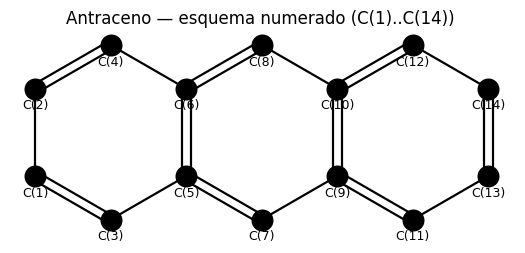


2) Figura ‚Äì Mono-aza e Di-aza com N destacados (mesma numera√ß√£o):


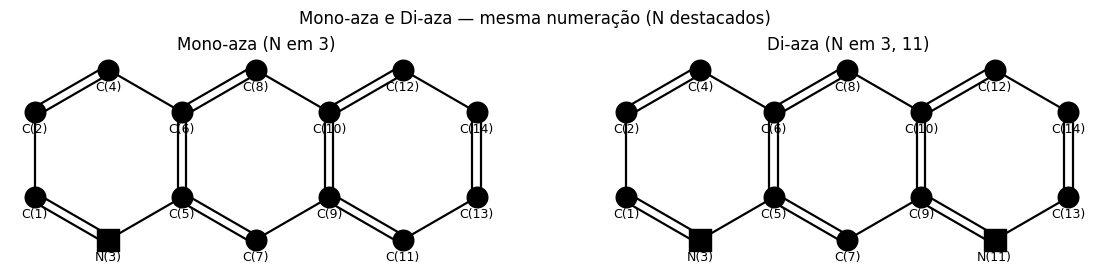


3) Tabela ‚Äì Matriz de conectividade (segundo numera√ß√£o 1..14):
(Abaixo: DataFrame com 1 = vizinho, 0 = n√£o vizinho)
       C(1)  C(2)  C(3)  C(4)  C(5)  C(6)  C(7)  C(8)  C(9)  C(10)  C(11)  \
C(1)      0     1     1     0     0     0     0     0     0      0      0   
C(2)      1     0     0     1     0     0     0     0     0      0      0   
C(3)      1     0     0     0     1     0     0     0     0      0      0   
C(4)      0     1     0     0     0     1     0     0     0      0      0   
C(5)      0     0     1     0     0     1     1     0     0      0      0   
C(6)      0     0     0     1     1     0     0     1     0      0      0   
C(7)      0     0     0     0     1     0     0     0     1      0      0   
C(8)      0     0     0     0     0     1     0     0     0      1      0   
C(9)      0     0     0     0     0     0     1     0     0      1      1   
C(10)     0     0     0     0     0     0     0     1     1      0      0   
C(11)     0     0     0     0  

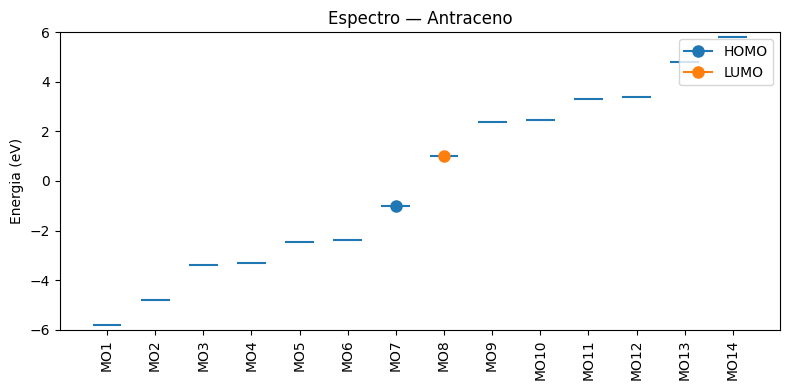


5) Tabela ‚Äì Autovalores EŒº/Œ≤ (Antraceno) com indica√ß√£o de ocupa√ß√£o:
      MO    E (eV)       E/Œ≤  ocupa√ß√£o (e)
0    MO1 -5.802330  2.320932      2.000000
1    MO2 -4.795209  1.918084      2.000000
2    MO3 -3.379303  1.351721      2.000000
3    MO4 -3.321829  1.328732      2.000000
4    MO5 -2.450788  0.980315      2.000000
5    MO6 -2.361693  0.944677      2.000000
6    MO7 -0.994106  0.397642      2.000000
7    MO8  0.994106 -0.397642      0.000000
8    MO9  2.361693 -0.944677      0.000000
9   MO10  2.450788 -0.980315      0.000000
10  MO11  3.321829 -1.328732      0.000000
11  MO12  3.379303 -1.351721      0.000000
12  MO13  4.795209 -1.918084      0.000000
13  MO14  5.802330 -2.320932      0.000000

6) Figura ‚Äì Espectros para mono-aza e di-aza (lado a lado):


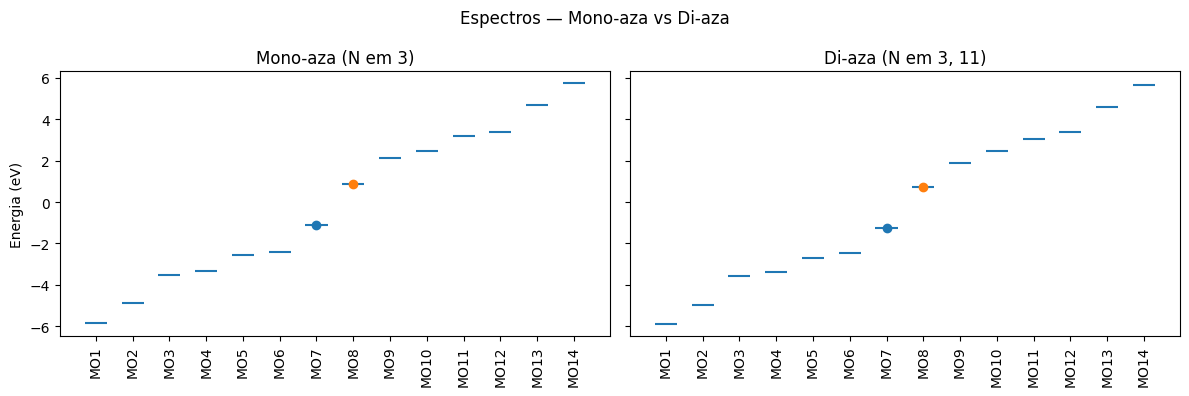


7) Tabela ‚Äì Popula√ß√µes q_i (Antraceno, Mono-aza, Di-aza):
    s√≠tio  q_i_antraceno  q_i_mono    q_i_di
0    C(1)       1.000000  0.858000  0.853000
1    C(2)       1.000000  1.013000  1.015000
2    C(3)       1.000000  1.239000  1.243000
3    C(4)       1.000000  0.925000  0.922000
4    C(5)       1.000000  0.974000  0.960000
5    C(6)       1.000000  1.001000  1.004000
6    C(7)       1.000000  1.018000  1.041000
7    C(8)       1.000000  0.980000  0.958000
8    C(9)       1.000000  0.994000  0.939000
9   C(10)       1.000000  1.001000  1.004000
10  C(11)       1.000000  1.003000  1.253000
11  C(12)       1.000000  0.996000  0.906000
12  C(13)       1.000000  0.996000  0.893000
13  C(14)       1.000000  1.001000  1.010000

8) Tabela ‚Äì Ordens p_ij para liga√ß√µes pr√≥ximas ao(s) N (mono-aza e di-aza):
       liga√ß√£o  pij_mono  tipo_x    pij_di  tipo_y
0    C(1)‚ÄìN(3)  0.779714  double  0.778030  double
1   C(9)‚ÄìN(11)         -       -  0.586895  double
2  N(11)‚ÄìC(13)    

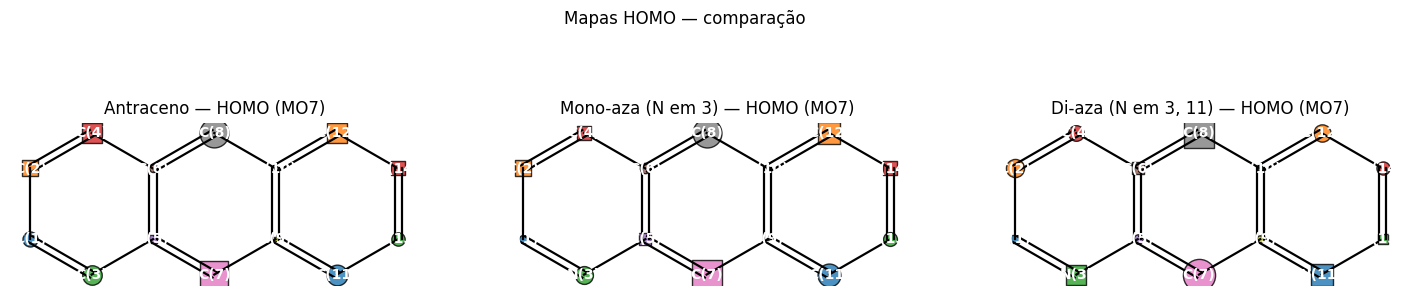


10) Figura ‚Äì Mapas LUMO (Antraceno, Mono-aza, Di-aza):


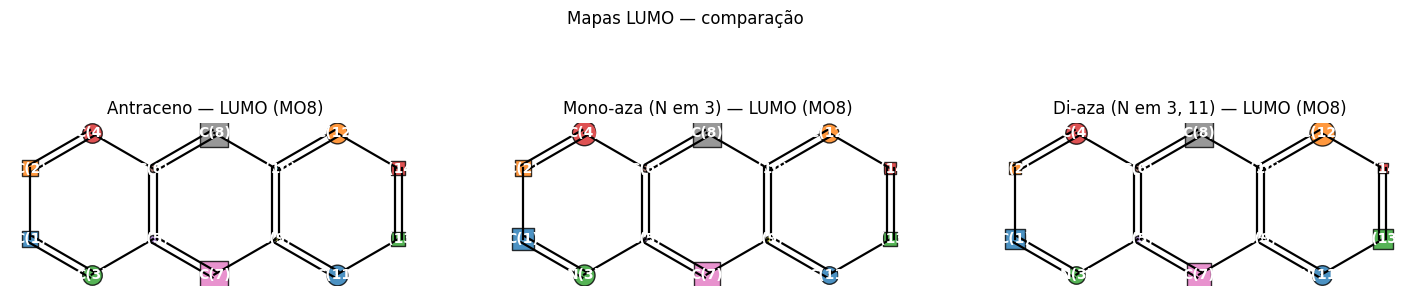

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt, isclose

# -------------------------
# 1) Par√¢metros
# -------------------------
beta0 = -2.5     # eV
alphaC = 0.0     # eV

# h_x (diagonal H_ii = alphaC + h[x]*beta0)
h = {
    "C": 0.0,
    "N_piridina": 0.5,
}

# k multiplicadores atualizados
k_single = {("C","C"): 0.9, ("C","N_piridina"): 0.8}
k_double = {("C","C"): 1.0, ("C","N_piridina"): 1.0}

# -------------------------
# 2) Geometria: construir 3 hex√°gonos e deduplicar (sep = sqrt(3) para 14 s√≠tios)
# -------------------------
def hexagono(cx=0.0, cy=0.0, r=1.0, rot_deg=0.0):
    angs = np.deg2rad(np.arange(6)*60.0 + rot_deg)
    xs = cx + r * np.cos(angs)
    ys = cy + r * np.sin(angs)
    return np.column_stack((xs, ys))

sep = sqrt(3.0)
r_hex = 1.0
centros = [(-sep,0.0), (0.0,0.0), (sep,0.0)]

pontos_raw = []
indices_por_anel_raw = []
for cx, cy in centros:
    verts = hexagono(cx, cy, r_hex, rot_deg=90.0)
    inicio = len(pontos_raw)
    pontos_raw.extend([tuple(v) for v in verts])
    indices_por_anel_raw.append(list(range(inicio, inicio+6)))

# deduplica√ß√£o por coord
unique_pts = []
map_raw_to_unique = {}
tol = 1e-8
for i, p in enumerate(pontos_raw):
    found = False
    for j, q in enumerate(unique_pts):
        if abs(p[0]-q[0]) < tol and abs(p[1]-q[1]) < tol:
            map_raw_to_unique[i] = j
            found = True
            break
    if not found:
        map_raw_to_unique[i] = len(unique_pts)
        unique_pts.append(p)

coords_unordered = np.array(unique_pts)
if coords_unordered.shape[0] != 14:
    raise RuntimeError(f"Esperado 14 s√≠tios ap√≥s deduplica√ß√£o, obtido {coords_unordered.shape[0]}")

# anel_map na indexa√ß√£o unordered (ordem local do anel)
anel_map_unordered = []
for anel in indices_por_anel_raw:
    anel_map_unordered.append([map_raw_to_unique[idx] for idx in anel])

# ordenar s√≠tios globalmente para r√≥tulos 1..14 (esquerda -> direita)
order = np.argsort(coords_unordered[:,0] + coords_unordered[:,1]*1e-3)
coords = coords_unordered[order]
n = coords.shape[0]   # =14
rotulos_base = [f"C({i+1})" for i in range(n)]

# mapa unordered -> ordered
map_unordered_to_ordered = {old_idx: int(np.where(order==old_idx)[0][0]) for old_idx in range(len(coords_unordered))}

# -------------------------
# 3) Atribuir tipos (double / single) localmente por anel 
#    e mapear para √≠ndices ordenados (preservando o tipo calculado localmente)
# -------------------------
bonds_type = {}  # (i_ord,j_ord) -> tipo 'double'/'single'
prioridade = {"single":0,"double":1}
for anel in anel_map_unordered:
    for k in range(6):
        u_i = anel[k]; u_j = anel[(k+1)%6]
        tipo_local = "double" if (k % 2 == 0) else "single"
        i_ord = map_unordered_to_ordered[u_i]; j_ord = map_unordered_to_ordered[u_j]
        a,b = min(i_ord,j_ord), max(i_ord,j_ord)
        if (a,b) in bonds_type:
            if prioridade[tipo_local] > prioridade[bonds_type[(a,b)]]:
                bonds_type[(a,b)] = tipo_local
        else:
            bonds_type[(a,b)] = tipo_local

# criar lista ordenada de liga√ß√µes
bonds_list = [(i,j,bonds_type[(i,j)]) for (i,j) in sorted(bonds_type.keys())]

# construir matriz de adjac√™ncia (connectivity) baseada nas liga√ß√µes definidas
adj = np.zeros((n,n), dtype=int)
for i,j,_ in bonds_list:
    adj[i,j] = adj[j,i] = 1

# -------------------------
# 4) Fun√ß√µes para k dependendo do tipo e dos √°tomos
# -------------------------
def k_para(at_i, at_j, tipo):
    key = (at_i, at_j)
    if tipo == "double":
        return k_double.get(key, k_double.get((at_j,at_i), k_double.get(("C","C"), 1.0)))
    else:
        return k_single.get(key, k_single.get((at_j,at_i), k_single.get(("C","C"), 0.9)))

# montar matriz H no formato pedido
def monta_H(atom_types):
    H = np.zeros((n,n), dtype=float)
    k_usados = {}
    for i, at in enumerate(atom_types):
        H[i,i] = alphaC + h.get(at, 0.0) * beta0
    for (i,j,tipo) in bonds_list:
        ai, aj = atom_types[i], atom_types[j]
        kij = k_para(ai, aj, tipo)
        H[i,j] = H[j,i] = kij * beta0
        k_usados[(i,j)] = kij
    return H, k_usados

# -------------------------
# 5) Sistemas: posi√ß√µes edit√°veis para N
#    por padr√£o: mono em 3; di em 3 e 11 (1-based)
# -------------------------
site_mono = 3
sites_di = (3, 11)
sistema_base = ["C"] * n
sistema_mono = sistema_base.copy(); sistema_mono[site_mono-1] = "N_piridina"
sistema_di = sistema_base.copy(); sistema_di[sites_di[0]-1] = "N_piridina"; sistema_di[sites_di[1]-1] = "N_piridina"

sistemas = [
    ("Antraceno", sistema_base),
    (f"Mono-aza (N em {site_mono})", sistema_mono),
    (f"Di-aza (N em {sites_di[0]}, {sites_di[1]})", sistema_di),
]

# -------------------------
# 6) Rotina de an√°lise que retorna resultados e produz os objetos pedidas
# -------------------------
def analisa_sistema(nome, atom_types):
    # monta H e diagonaliza
    H, k_usados = monta_H(atom_types)
    evals, evecs = np.linalg.eigh(H)

    # preenchimento: 1 el√©tron por s√≠tio -> nelec = 14
    nelec = n
    full_occ = nelec // 2
    half_occ = nelec % 2
    occ_vec = np.zeros(n, dtype=float)
    occ_vec[:full_occ] = 2.0
    if half_occ:
        occ_vec[full_occ] = 1.0

    # √≠ndices HOMO / LUMO
    occupied_idx = np.where(occ_vec > 0)[0]
    unoccupied_idx = np.where(occ_vec == 0)[0]
    HOMO_idx = int(occupied_idx.max()) if occupied_idx.size else None
    LUMO_idx = int(unoccupied_idx.min()) if unoccupied_idx.size else None

    # popula√ß√µes e matriz densidade
    populations = np.sum((evecs**2) * occ_vec, axis=1)
    P = np.zeros((n,n))
    for mu in range(n):
        P += occ_vec[mu] * np.outer(evecs[:,mu], evecs[:,mu])

    # r√≥tulos display (trocar C(i) por N(i) onde houver N)
    labels = rotulos_base.copy()
    for i, at in enumerate(atom_types):
        if at.startswith("N"):
            labels[i] = f"N({i+1})"

    # montar DataFrames/Tabelas necess√°rias
    df_H = pd.DataFrame(np.round(H, 6), index=labels, columns=labels)
    df_adj = pd.DataFrame(adj, index=labels, columns=labels)
    df_evals = pd.DataFrame({
        "MO": [f"MO{m+1}" for m in range(n)],
        "E (eV)": evals,
        "E/Œ≤": evals / beta0,
        "ocupa√ß√£o (e)": occ_vec
    })
    df_pop = pd.DataFrame({"s√≠tio": labels, "q_i": populations})
    # ordens p_ij para liga√ß√µes pr√≥ximas a N -> coletar liga√ß√µes que envolvem N
    pijs = []
    for (i,j,tipo) in bonds_list:
        if atom_types[i].startswith("N") or atom_types[j].startswith("N"):
            pijs.append({"liga√ß√£o": f"{labels[i]}‚Äì{labels[j]}", "p_ij": float(P[i,j]), "tipo": tipo})
    df_pij_proxN = pd.DataFrame(pijs)

    resultados = {
        "H": H, "k_usados": k_usados, "evals": evals, "evecs": evecs,
        "occ_vec": occ_vec, "HOMO_idx": HOMO_idx, "LUMO_idx": LUMO_idx,
        "populations": populations, "P": P,
        "labels": labels, "df_H": df_H, "df_adj": df_adj,
        "df_evals": df_evals, "df_pop": df_pop, "df_pij_proxN": df_pij_proxN
    }
    return resultados

# rodar os 3 sistemas e guardar resultados
resultados = {}
for nome, atypes in sistemas:
    resultados[nome] = analisa_sistema(nome, atypes)

# -------------------------
# 7) Entrega: imprimir e plotar na ORDEM EXATA pedida
#    (cada se√ß√£o tem coment√°rio; todas as figuras/tabelas aparecem nesta ordem)
# -------------------------

# 0) helpers para plotar mapas MO e esquema
def desenha_lig(ax, p1, p2, tipo, largura=1.6, desloc=0.05):
    x1,y1 = p1; x2,y2 = p2
    dx, dy = x2-x1, y2-y1
    comp = np.hypot(dx, dy)
    if comp == 0:
        return
    perp = np.array([-dy, dx]) / comp
    if tipo == "double":
        off = perp * desloc
        ax.plot([x1+off[0], x2+off[0]], [y1+off[1], y2+off[1]], linewidth=largura, color='k')
        ax.plot([x1-off[0], x2-off[0]], [y1-off[1], y2-off[1]], linewidth=largura, color='k')
    else:
        ax.plot([x1,x2],[y1,y2], linewidth=largura, color='k')

def plot_esquema_numerado(nome, labels, atom_types, title_suffix=""):
    fig, ax = plt.subplots(figsize=(10,2.6))
    for (i,j,tipo) in bonds_list:
        desenha_lig(ax, coords[i], coords[j], tipo)
    for i,(x,y) in enumerate(coords):
        marker = 's' if atom_types[i].startswith("N") else 'o'
        ax.scatter(x, y, s=260 if atom_types[i].startswith("N") else 220, marker=marker,
                   facecolors='k', edgecolors='k', zorder=5)
        ax.text(x, y-0.12, labels[i], ha='center', va='top', fontsize=9, color='k')
    ax.set_aspect('equal'); ax.axis('off')
    ax.set_title(f"{nome} {title_suffix}")
    plt.show()

def plot_map_MOs_list(evecs_list, idx_list, labels_list, title_prefix, cmap=None):
    # evecs_list: list of evec arrays (one per sistema)
    # idx_list: MO index to plot for each (HOMO/LUMO)
    nsys = len(evecs_list)
    fig, axes = plt.subplots(1, nsys, figsize=(6*nsys, 3))
    if nsys == 1:
        axes = [axes]
    for ax, evecs, idx, labels in zip(axes, evecs_list, idx_list, labels_list):
        # desenhar liga√ß√µes
        for (i,j,tipo) in bonds_list:
            desenha_lig(ax, coords[i], coords[j], tipo, largura=1.2)
        for i,(x,y) in enumerate(coords):
            c = evecs[i, idx]
            tam = 2200 * (c**2) if not isclose(c,0.0) else 40
            marcador = 'o' if c >= 0 else 's'
            ax.scatter(x, y, s=tam, marker=marcador, alpha=0.7, edgecolors='k')
            ax.text(x, y, labels[i], ha='center', va='center', color='white', weight='bold')
        ax.set_aspect('equal'); ax.axis('off')
        ax.set_title(f"{title_prefix} ‚Äî {labels[0]}...")  # t√≠tulo simples
    plt.show()

# --------------------------------------------
# ENTREGAS NA ORDEM 
# --------------------------------------------

# ------------- MATRIZES H -------------
print("\nMatriz H ‚Äî Antraceno:")
print(resultados["Antraceno"]["df_H"])

print("\nMatriz H ‚Äî Mono-aza:")
print(resultados[f"Mono-aza (N em {site_mono})"]["df_H"])

print("\nMatriz H ‚Äî Di-aza:")
print(resultados[f"Di-aza (N em {sites_di[0]}, {sites_di[1]})"]["df_H"])

# 1) Figura ‚Äì Esquema do antraceno numerado.
print("\n1) Figura ‚Äì Esquema do antraceno numerado:")
nome0, atypes0 = sistemas[0]
labels0 = resultados[nome0]["labels"]
plot_esquema_numerado(f"{nome0} ‚Äî esquema numerado (C(1)..C(14))", labels0, atypes0)

# 2) Figura ‚Äì Esquemas do mono-aza e do di-aza (mesma numera√ß√£o), com N destacados.
print("\n2) Figura ‚Äì Mono-aza e Di-aza com N destacados (mesma numera√ß√£o):")
nome1, atypes1 = sistemas[1]; labels1 = resultados[nome1]["labels"]
nome2, atypes2 = sistemas[2]; labels2 = resultados[nome2]["labels"]
# plot lado a lado
fig, axes = plt.subplots(1,2, figsize=(14,3))
for ax, nome, labels_sys, types_sys in zip(axes, [nome1, nome2], [labels1, resultados[nome2]["labels"]], [sistemas[1][1], sistemas[2][1]]):
    # desenhar liga√ß√µes e pontos no eixo ax
    for (i,j,tipo) in bonds_list:
        desenha_lig(ax, coords[i], coords[j], tipo)
    for i,(x,y) in enumerate(coords):
        marker = 's' if types_sys[i].startswith("N") else 'o'
        ax.scatter(x,y, s=260 if types_sys[i].startswith("N") else 220,
                   marker=marker, facecolors='k', edgecolors='k', zorder=5)
        ax.text(x, y-0.12, labels_sys[i], ha='center', va='top', fontsize=9, color='k')
    ax.set_aspect('equal'); ax.axis('off')
    ax.set_title(nome)
plt.suptitle("Mono-aza e Di-aza ‚Äî mesma numera√ß√£o (N destacados)")
plt.show()

# 3) Tabela ‚Äì Matriz de conectividade (ou lista de vizinhos) segundo a sua numera√ß√£o.
print("\n3) Tabela ‚Äì Matriz de conectividade (segundo numera√ß√£o 1..14):")
print("(Abaixo: DataFrame com 1 = vizinho, 0 = n√£o vizinho)")
print(resultados[nome0]["df_adj"])

# tamb√©m imprimir lista de vizinhos (forma mais leg√≠vel)
print("\nLista de vizinhos (por s√≠tio):")
for i, label in enumerate(resultados[nome0]["labels"]):
    vizinhos = [resultados[nome0]["labels"][j] for j in range(n) if resultados[nome0]["df_adj"].iloc[i,j] == 1]
    print(f"{label}: {', '.join(vizinhos)}")

# 4) Figura ‚Äì Espectro de energias do antraceno com HOMO/LUMO marcados.
print("\n4) Figura ‚Äì Espectro de energias do antraceno (HOMO/LUMO marcados):")
evs0 = resultados[nome0]["evals"]
HOMO0 = resultados[nome0]["HOMO_idx"]
LUMO0 = resultados[nome0]["LUMO_idx"]
fig, ax = plt.subplots(figsize=(8,4))
xs = np.arange(1, n+1)
ax.hlines(evs0, xs-0.3, xs+0.3)
ax.set_xticks(xs); ax.set_xticklabels([f"MO{j}" for j in range(1,n+1)], rotation=90)
if HOMO0 is not None: 
    ax.plot(HOMO0+1, evs0[HOMO0], marker='o', markersize=8, label='HOMO')
if LUMO0 is not None: 
    ax.plot(LUMO0+1, evs0[LUMO0], marker='o', markersize=8, label='LUMO')
ax.set_ylim(-6, 6)
ax.set_ylabel("Energia (eV)"); ax.set_title("Espectro ‚Äî Antraceno")
ax.legend(); plt.tight_layout(); plt.show()


# 5) Tabela ‚Äì Autovalores EŒº/Œ≤ (antraceno) com indica√ß√£o de ocupa√ß√£o.
print("\n5) Tabela ‚Äì Autovalores EŒº/Œ≤ (Antraceno) com indica√ß√£o de ocupa√ß√£o:")
df_evals0 = resultados[nome0]["df_evals"].copy()
# formatar E/Œ≤ com 6 casas
df_evals0["E/Œ≤"] = df_evals0["E/Œ≤"].round(6)
print(df_evals0)

# 6) Figura ‚Äì Espectros para mono-aza e di-aza (lado a lado).
print("\n6) Figura ‚Äì Espectros para mono-aza e di-aza (lado a lado):")
evs1 = resultados[nome1]["evals"]; evs2 = resultados[nome2]["evals"]
fig, axes = plt.subplots(1,2, figsize=(12,4), sharey=True)
for ax, evs, nome_sys, res in zip(axes, [evs1, evs2], [nome1, nome2], [resultados[nome1], resultados[nome2]]):
    xs = np.arange(1, n+1)
    ax.hlines(evs, xs-0.3, xs+0.3)
    ax.set_xticks(xs); ax.set_xticklabels([f"MO{j}" for j in range(1,n+1)], rotation=90)
    Hidx = res["HOMO_idx"]; Lidx = res["LUMO_idx"]
    if Hidx is not None: ax.plot(Hidx+1, evs[Hidx], marker='o', label='HOMO')
    if Lidx is not None: ax.plot(Lidx+1, evs[Lidx], marker='o', label='LUMO')
    ax.set_title(nome_sys)
axes[0].set_ylabel("Energia (eV)")
plt.suptitle("Espectros ‚Äî Mono-aza vs Di-aza")
plt.tight_layout(); plt.show()

# 7) Tabela ‚Äì Popula√ß√µes q_i (antraceno, mono-aza, di-aza).
print("\n7) Tabela ‚Äì Popula√ß√µes q_i (Antraceno, Mono-aza, Di-aza):")
# criar DataFrame agregando as tr√™s colunas q_i lado a lado
df_pop_all = pd.DataFrame({"s√≠tio": resultados[nome0]["labels"],
                           "q_i_antraceno": resultados[nome0]["populations"],
                           "q_i_mono": resultados[nome1]["populations"],
                           "q_i_di": resultados[nome2]["populations"]})
# arredondar para 3 casas
df_pop_all[["q_i_antraceno","q_i_mono","q_i_di"]] = df_pop_all[["q_i_antraceno","q_i_mono","q_i_di"]].round(3)
print(df_pop_all)

# 8) Tabela ‚Äì Ordens p_ij para liga√ß√µes pr√≥ximas ao(s) N.
print("\n8) Tabela ‚Äì Ordens p_ij para liga√ß√µes pr√≥ximas ao(s) N (mono-aza e di-aza):")
# juntar as tabelas df_pij_proxN de mono e di, alinhando pela liga√ß√£o
df_pij_mono = resultados[nome1]["df_pij_proxN"].copy()
df_pij_mono = df_pij_mono.rename(columns={"p_ij": "pij_mono"})
df_pij_di = resultados[nome2]["df_pij_proxN"].copy()
df_pij_di = df_pij_di.rename(columns={"p_ij": "pij_di"})
# mesclar por 'liga√ß√£o'
df_pij_merge = pd.merge(df_pij_mono, df_pij_di, on="liga√ß√£o", how="outer")
# mostrar
print(df_pij_merge.fillna("-"))

# 9) Figura ‚Äì Mapas HOMO (antraceno, mono-aza, di-aza).
print("\n9) Figura ‚Äì Mapas HOMO (Antraceno, Mono-aza, Di-aza):")
evecs0 = resultados[nome0]["evecs"]; evecs1 = resultados[nome1]["evecs"]; evecs2 = resultados[nome2]["evecs"]
Hidx0 = resultados[nome0]["HOMO_idx"]; Hidx1 = resultados[nome1]["HOMO_idx"]; Hidx2 = resultados[nome2]["HOMO_idx"]
labels0 = resultados[nome0]["labels"]; labels1 = resultados[nome1]["labels"]; labels2 = resultados[nome2]["labels"]
# plot lado a lado (3 colunas)
fig, axes = plt.subplots(1,3, figsize=(18,4))
for ax, evecs, Hidx, labels_sys, nome_sys in zip(axes, [evecs0,evecs1,evecs2], [Hidx0,Hidx1,Hidx2], [labels0,labels1,labels2], [nome0,nome1,nome2]):
    for (i,j,tipo) in bonds_list:
        desenha_lig(ax, coords[i], coords[j], tipo)
    for i,(x,y) in enumerate(coords):
        c = evecs[i, Hidx]
        tam = 2200 * (c**2) if not isclose(c,0.0) else 40
        marcador = 'o' if c >= 0 else 's'
        ax.scatter(x,y, s=tam, marker=marcador, alpha=0.8, edgecolors='k')
        ax.text(x,y, labels_sys[i], ha='center', va='center', color='white', weight='bold')
    ax.set_aspect('equal'); ax.axis('off'); ax.set_title(f"{nome_sys} ‚Äî HOMO (MO{Hidx+1})")
plt.suptitle("Mapas HOMO ‚Äî compara√ß√£o")
plt.show()

# 10) Figura ‚Äì Mapas LUMO (antraceno, mono-aza, di-aza).
print("\n10) Figura ‚Äì Mapas LUMO (Antraceno, Mono-aza, Di-aza):")
Lidx0 = resultados[nome0]["LUMO_idx"]; Lidx1 = resultados[nome1]["LUMO_idx"]; Lidx2 = resultados[nome2]["LUMO_idx"]
fig, axes = plt.subplots(1,3, figsize=(18,4))
for ax, evecs, Lidx, labels_sys, nome_sys in zip(axes, [evecs0,evecs1,evecs2], [Lidx0,Lidx1,Lidx2], [labels0,labels1,labels2], [nome0,nome1,nome2]):
    for (i,j,tipo) in bonds_list:
        desenha_lig(ax, coords[i], coords[j], tipo)
    for i,(x,y) in enumerate(coords):
        c = evecs[i, Lidx]
        tam = 2200 * (c**2) if not isclose(c,0.0) else 40
        marcador = 'o' if c >= 0 else 's'
        ax.scatter(x,y, s=tam, marker=marcador, alpha=0.8, edgecolors='k')
        ax.text(x,y, labels_sys[i], ha='center', va='center', color='white', weight='bold')
    ax.set_aspect('equal'); ax.axis('off'); ax.set_title(f"{nome_sys} ‚Äî LUMO (MO{Lidx+1})")
plt.suptitle("Mapas LUMO ‚Äî compara√ß√£o")
plt.show()


# 11) Texto final ‚Äî Compara√ß√£o cr√≠tica (8‚Äì12 linhas)
O espectro eletr√¥nico do antraceno mostra um conjunto de n√≠veis œÄ bem distribu√≠dos, com um gap HOMO‚ÄìLUMO relativamente pequeno, coerente com sua natureza arom√°tica estendida. A inser√ß√£o de nitrog√™nio (mono-aza e di-aza) altera esse padr√£o, deslocando energias e redistribuindo densidades eletr√¥nicas. As popula√ß√µes ùëûùëñ evidenciam que os √°tomos de N retiram densidade eletr√¥nica de carbonos vizinhos, ao mesmo tempo em que acumulam carga negativa, o que se reflete em uma polariza√ß√£o local da rede œÄ. As ordens de liga√ß√£o ùëùùëñùëó pr√≥ximas ao N confirmam essa perturba√ß√£o, com diminui√ß√£o relativa em compara√ß√£o √†s liga√ß√µes C‚ÄìC puras do antraceno. No caso do di-aza, a presen√ßa de dois nitrog√™nios introduz assimetrias adicionais, reduzindo ainda mais a ordem de certas liga√ß√µes e promovendo diferen√ßas locais mais pronunciadas. Em termos de estabilidade e reatividade, isso sugere que o antraceno puro possui maior delocaliza√ß√£o e simetria, enquanto as variantes aza apresentam maior polariza√ß√£o e poss√≠veis s√≠tios mais reativos. Portanto, a compara√ß√£o mostra que a substitui√ß√£o por nitrog√™nio rompe parcialmente a simetria eletr√¥nica do antraceno, modificando tanto o espectro de energias quanto a distribui√ß√£o de densidade œÄ, o que impacta diretamente suas propriedades eletr√¥nicas e qu√≠micas.
